# Project 1: Digit Classification with KNN and Naive Bayes

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [144]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.

In [145]:
# Load the digit data either from mldata.org, or once downloaded to data_home, from disk. The data is about 53MB so this cell
# should take a while the first time your run it.
mnist = fetch_mldata('MNIST original', data_home='~/datasets/mnist')
X, Y = mnist.data, mnist.target

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print 'data shape: ', X.shape
print 'label shape:', Y.shape

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000L, 784L)
label shape: (70000L,)


(1) Create a 10x10 grid to visualize 10 examples of each digit. Python hints:

- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

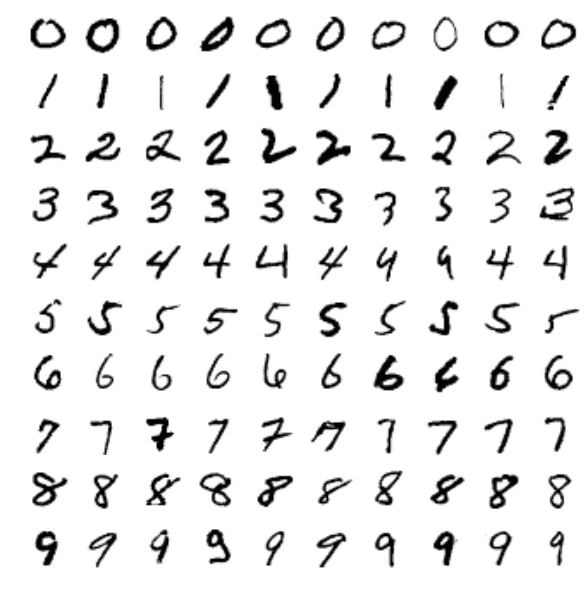

In [146]:
def P1(num_examples=10):    
    # Keep track of digit count
    digCount = np.zeros(10)            
    fig = plt.figure(figsize=(10, num_examples))   
    i = 0   

    # Loop till each digit has 10 examples filled
    while (digCount != num_examples).any():      
        if digCount[Y[i]] != num_examples:                                                         
            digCount[Y[i]] += 1
            # Parse and reshape associated matrix
            mat = np.reshape(X[i,], (28,28))     
            # Setup subplot number
            subplot_num = Y[i] * num_examples + digCount[Y[i]]              
            plt.subplot(10, num_examples, subplot_num)         
            plt.imshow(mat, cmap = "Greys")                    
            plt.axis('off')                                       
        i += 1                                 
P1(10)

(2) Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?

- KNeighborsClassifier() for fitting and predicting
- classification_report() for producing precision, recall, F1 results

In [148]:
def P2(k_values):
    # Loop through each k value
    for k in k_values:
        neigh = KNeighborsClassifier(n_neighbors=k)
        neigh.fit(mini_train_data, mini_train_labels)
        preds = neigh.predict(dev_data)
        correct, total = 0, 0
        for pred, label in zip(preds, dev_labels):
            if pred == label: correct += 1
            total += 1
        print 'k: ' + `k` + ' total: %3d  correct: %3d  accuracy: %3.2f' %(total, correct, 1.0*correct/total)            
        # Display classification report for k = 1
        if k == 1: print(classification_report(dev_labels, preds))
    
k_values = [1, 3, 5, 7, 9]
P2(k_values)


k: 1 total: 1000  correct: 888  accuracy: 0.89
             precision    recall  f1-score   support

        0.0       0.91      0.98      0.94        99
        1.0       0.89      1.00      0.94       105
        2.0       0.99      0.79      0.88       102
        3.0       0.77      0.87      0.82        86
        4.0       0.89      0.82      0.85       104
        5.0       0.93      0.84      0.88        91
        6.0       0.94      0.96      0.95        98
        7.0       0.89      0.92      0.90       113
        8.0       0.94      0.88      0.91        96
        9.0       0.78      0.82      0.80       106

avg / total       0.89      0.89      0.89      1000

k: 3 total: 1000  correct: 878  accuracy: 0.88
k: 5 total: 1000  correct: 869  accuracy: 0.87
k: 7 total: 1000  correct: 865  accuracy: 0.86
k: 9 total: 1000  correct: 863  accuracy: 0.86


ANSWER: 3 is the most difficult digit with a precision of just 0.77.

(3) Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.

- time.time() gives a wall clock value you can use for timing operations

In [149]:
def P3(train_sizes, accuracies):
    # Loop through each train size
    for train_size in train_sizes:
        # Track time
        startTime = time.time()
        neigh = KNeighborsClassifier(n_neighbors=1)
        neigh.fit(train_data[:train_size], train_labels[:train_size])
        preds = neigh.predict(dev_data)
        correct, total = 0, 0
        for pred, label in zip(preds, dev_labels):
            if pred == label: correct += 1
            total += 1
        accuracy = 1.0*correct/total
        accuracies.append(accuracy)
        print 'train size: ' + `train_size` + ' - total: %3d  correct: %3d  accuracy: %3.2f' %(total, correct, accuracy)    
        endTime = time.time()
        print "time taken: " + `(endTime - startTime)` + " seconds"

train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracies = []
P3(train_sizes, accuracies)

train size: 100 - total: 1000  correct: 720  accuracy: 0.72
time taken: 0.12400007247924805 seconds
train size: 200 - total: 1000  correct: 786  accuracy: 0.79
time taken: 0.22499990463256836 seconds
train size: 400 - total: 1000  correct: 841  accuracy: 0.84
time taken: 0.4780001640319824 seconds
train size: 800 - total: 1000  correct: 884  accuracy: 0.88
time taken: 0.9909999370574951 seconds
train size: 1600 - total: 1000  correct: 902  accuracy: 0.90
time taken: 2.0409998893737793 seconds
train size: 3200 - total: 1000  correct: 926  accuracy: 0.93
time taken: 4.169000148773193 seconds
train size: 6400 - total: 1000  correct: 937  accuracy: 0.94
time taken: 8.458999872207642 seconds
train size: 12800 - total: 1000  correct: 959  accuracy: 0.96
time taken: 17.591000080108643 seconds
train size: 25000 - total: 1000  correct: 970  accuracy: 0.97
time taken: 36.88700008392334 seconds


(4) Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?

- Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

In [150]:
def P4():
    linearModel = LinearRegression()
    # Reshape train size vector and fit with accuracies
    linearModel.fit(np.reshape(train_sizes,(9,1)), accuracies)
    pred = linearModel.predict(60000)
    print "Linear Regression n=60000 accuracy: " + `pred[0]`
      
    transformModel = LinearRegression()
    # Transform size and accuracy by log
    transform_sizes = [np.log(size) for size in train_sizes]
    # Transform accuracy to log(accuracy/(1-accuracy)) to ensure asymptotic 100% prediction
    new_accuracies = [np.log(accuracy/(1-accuracy)) for accuracy in accuracies]
    transformModel.fit(np.reshape(transform_sizes,(9,1)), new_accuracies)
    predT = transformModel.predict(np.log(60000))
    # Reverse transformation to get actual predicted value
    transformPred = np.exp(predT)/(1+np.exp(predT))
    print "Transformed Linear Regression n=60000 accuracy: " + `transformPred[0]`

P4()

Linear Regression n=60000 accuracy: 1.2430722589090419
Transformed Linear Regression n=60000 accuracy: 0.97851419544697282


ANSWER: 1.24, regression assumes that accuracy can go above 1.00 when that is impossible.

Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

- confusion_matrix() produces a confusion matrix

[[ 97   0   0   0   0   0   2   0   0   0]
 [  0 105   0   0   0   0   0   0   0   0]
 [  4   4  81   4   0   0   0   4   3   2]
 [  1   0   0  75   0   3   0   3   1   3]
 [  0   2   0   0  85   0   3   0   0  14]
 [  2   0   0   9   0  76   0   1   1   2]
 [  1   1   1   0   1   0  94   0   0   0]
 [  1   4   0   1   1   0   0 104   0   2]
 [  0   2   0   5   0   2   1   0  84   2]
 [  1   0   0   3   9   1   0   5   0  87]]


From observing the confusion matrix, it is clear that the most confused pair of digits are 4s confused to be 9s.


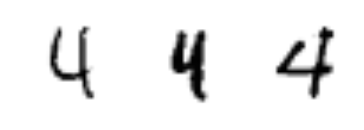

In [151]:
def P5():
    neigh = KNeighborsClassifier(n_neighbors=1)
    neigh.fit(mini_train_data, mini_train_labels)
    preds = neigh.predict(dev_data)
    print(confusion_matrix(dev_labels, preds))
    print "\n"
    print "From observing the confusion matrix, it is clear that the most confused pair of digits are 4s confused to be 9s."
            
    i = 0
    confCount = 0
    
    # Show three examples
    while confCount < 3:
        if dev_labels[i] == 4 and preds[i] == 9:
            mat = np.reshape(dev_data[i,], (28,28))
            plt.subplot(1, 3, confCount+1)
            plt.imshow(mat, cmap = 'Greys')
            plt.axis('off')
            confCount += 1
        i += 1

P5()

(6) A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.

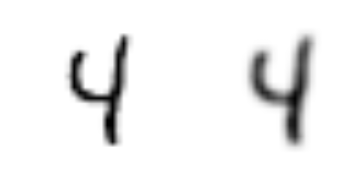

Preprocessing training data but not dev data:
total: 1000  correct: 907  accuracy: 0.91
Preprocessing dev data but not training data:
total: 1000  correct: 876  accuracy: 0.88
Preprocessing both training and dev data:
total: 1000  correct: 902  accuracy: 0.90


In [152]:
def P6():   
    def blur(data, weights):        
        blurData = np.zeros(data.shape)
        # For each row in original data
        for i in range(data.shape[0]):
            # Reshape to 28x28 matrix
            mat = np.reshape(data[i], (28,28))
            blurMat = np.zeros((28, 28))
            for j in range(1, 27):
                for k in range(1, 27):
                    for l in range(-1, 2):
                        for m in range(-1, 2):
                            # Add weighted value to blurred matrix
                            blurMat[j][k] += mat[j+l][k+m] * weights[l+1][m+1]
            # Reshape blurred matrix to match original data shape
            blurData[i] = np.reshape(blurMat, (1, 784))
        return blurData        
    
    def clfAcc(trainX, trainY, testX, testY):
        # Setup classifier and check accuracy for each case
        clf = KNeighborsClassifier(n_neighbors=1)
        clf.fit(trainX, trainY) 
        preds = clf.predict(testX)
        correct, total = 0, 0
        for pred, label in zip(preds, testY):
            if pred == label: correct += 1
            total += 1
        print 'total: %3d  correct: %3d  accuracy: %3.2f' %(total, correct, 1.0*correct/total)             
    
    sigma = 1
    weights = np.zeros((3, 3))
    totWeight = 0
    for i in range (-1, 2):
        for j in range (-1, 2):
            # Use 2d gaussian blur formula to assign weight: http://en.wikipedia.org/wiki/Gaussian_blur
            weights[i+1][j+1] = (1/(2 * np.pi * sigma**2))*np.exp(-1 * (i**2 + j**2)/(2 * sigma**2))
            totWeight += weights[i+1][j+1]

    # Normalize weights
    for i in range (0, 3):
        for j in range(0, 3):
            weights[i][j] = weights[i][j]/totWeight
    
    # Preprocess train data and dev data
    b_mini_train_data = blur(mini_train_data, weights)
    b_dev_data = blur(dev_data, weights)
    
    # Before blur example
    mat1 = np.reshape(dev_data[0,], (28,28))
    plt.subplot(1, 2, 1)
    plt.imshow(mat1, cmap = 'Greys')
    plt.axis('off')
    
    # After blur example
    mat2 = np.reshape(b_dev_data[0,], (28,28))
    plt.subplot(1, 2, 2)
    plt.imshow(mat2, cmap = 'Greys')
    plt.axis('off')   
    plt.show()    
        
    print 'Preprocessing training data but not dev data:'
    clfAcc(b_mini_train_data, mini_train_labels, dev_data, dev_labels)
    print 'Preprocessing dev data but not training data:'
    clfAcc(mini_train_data, mini_train_labels, b_dev_data, dev_labels)
    print 'Preprocessing both training and dev data:'
    clfAcc(b_mini_train_data, mini_train_labels, b_dev_data, dev_labels)

P6()


ANSWER: Blurring the training data seems to have the best accuracy.

(7) Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?

In [153]:

def P7():
    # Fit BernoulliNB with <0.5 considered to be 0 and >0.5 to be 1
    clf = BernoulliNB(alpha=1.0, binarize=0.5, class_prior=None, fit_prior=True)
    clf.fit(mini_train_data, mini_train_labels)       
    preds = clf.predict(dev_data)
    correct, total = 0, 0
    for pred, label in zip(preds, dev_labels):
        if pred == label: correct += 1
        total += 1
    print 'BinomialNB - total: %3d  correct: %3d  accuracy: %3.2f' %(total, correct, 1.0*correct/total)       

    # map pixel values to 0, 1 or 2
    multiAdj = mini_train_data * 2
    multiAdj = np.rint(multiAdj)
    
    clf = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
    clf.fit(multiAdj, mini_train_labels)
    preds = clf.predict(dev_data)
    correct, total = 0, 0
    for pred, label in zip(preds, dev_labels):
        if pred == label: correct += 1
        total += 1
    print 'MultinomialNB - total: %3d  correct: %3d  accuracy: %3.2f' %(total, correct, 1.0*correct/total)       
    
P7()

BinomialNB - total: 1000  correct: 817  accuracy: 0.82
MultinomialNB - total: 1000  correct: 801  accuracy: 0.80


ANSWER: There are only really two colors in the digit images, so assuming three does not improve accuracy as one might expect. So the MultinomialNB does not improve the results.

(8) Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?

- Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

In [163]:
def P8(alphas):       
    clf = BernoulliNB(binarize=0.5, fit_prior=True, class_prior=None)
    # Perform Grid Search
    clfGrid = GridSearchCV(clf, alphas)
    clfGrid.fit(train_data, train_labels)    
    
    print nb.best_params_
    clf = BernoulliNB(alpha=0.0001, fit_prior=True, class_prior=None)
    clf.fit(train_data, train_labels)
    print 'Bernoulli NB model accuracy with alpha = 0.0001: %3.4f' %(clf.score(train_data, train_labels))    
    
    # Run Bernoulli NB for alpha = 0
    clf = BernoulliNB(alpha=0.0, fit_prior=True, class_prior=None)
    clf.fit(train_data, train_labels)
    print 'Bernoulli NB model accuracy with alpha = 0: %3.4f' %(clf.score(train_data, train_labels))
    return clfGrid

alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
nb = P8(alphas)

{'alpha': 0.0001}
Bernoulli NB model accuracy with alpha = 0.0001: 0.8341
Bernoulli NB model accuracy with alpha = 0: 0.0989


In [164]:
print nb.best_params_

{'alpha': 0.0001}


ANSWER: The accuracy with alpha = 0 is a dismal 0.0989, which  is understandable since this means there is no smoothing done.

(9) Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

In [165]:
def P9():
    # Train Gaussian NB
    clf = GaussianNB()
    clf.fit(mini_train_data, mini_train_labels)       
    preds = clf.predict(dev_data)
    correct, total = 0, 0
    for pred, label in zip(preds, dev_labels):
        if pred == label: correct += 1
        total += 1
    print 'GuassianNB - total: %3d  correct: %3d  accuracy: %3.2f' %(total, correct, 1.0*correct/total)           
    print 'theta: ' + str(clf.theta_)
    print 'sigma: ' + str(clf.sigma_)
    
    # Add random noise since sigma and theta values are near-zero
    adj_mini_train_data = np.zeros(mini_train_data.shape)
    for i in range(mini_train_data.shape[0]):
        for j in range(mini_train_data.shape[1]):
            adj_mini_train_data[i][j] = mini_train_data[i][j] + 0.5 * np.random.rand()

    # Train Gaussian NB on adjusted data
    clf = GaussianNB()
    clf.fit(adj_mini_train_data, mini_train_labels)       
    preds = clf.predict(dev_data)
    correct, total = 0, 0
    for pred, label in zip(preds, dev_labels):
        if pred == label: correct += 1
        total += 1
    print 'Adjusted GuassianNB - total: %3d  correct: %3d  accuracy: %3.2f' %(total, correct, 1.0*correct/total)         
    
gnb = P9()

GuassianNB - total: 1000  correct: 627  accuracy: 0.63
theta: [[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
sigma: [[  1.00000000e-09   1.00000000e-09   1.00000000e-09 ...,   1.00000000e-09
    1.00000000e-09   1.00000000e-09]
 [  1.00000000e-09   1.00000000e-09   1.00000000e-09 ...,   1.00000000e-09
    1.00000000e-09   1.00000000e-09]
 [  1.00000000e-09   1.00000000e-09   1.00000000e-09 ...,   1.00000000e-09
    1.00000000e-09   1.00000000e-09]
 ..., 
 [  1.00000000e-09   1.00000000e-09   1.00000000e-09 ...,   1.00000000e-09
    1.00000000e-09   1.00000000e-09]
 [  1.00000000e-09   1.00000000e-09   1.00000000e-09 ...,   1.00000000e-09
    1.00000000e-09   1.00000000e-09]
 [  1.00000000e-09   1.00000000e-09   1.00000000e-09 ...,   1.00000000e-09
    1.00000000e-09   1.00000000e-09]]
Adjusted GuassianNB - total: 1000  correct: 809  ac

ANSWER: The theta (mean) and sigma (standard deviation) is near-zero. Adding random noise increased accuracy to near 80%.

(10) Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

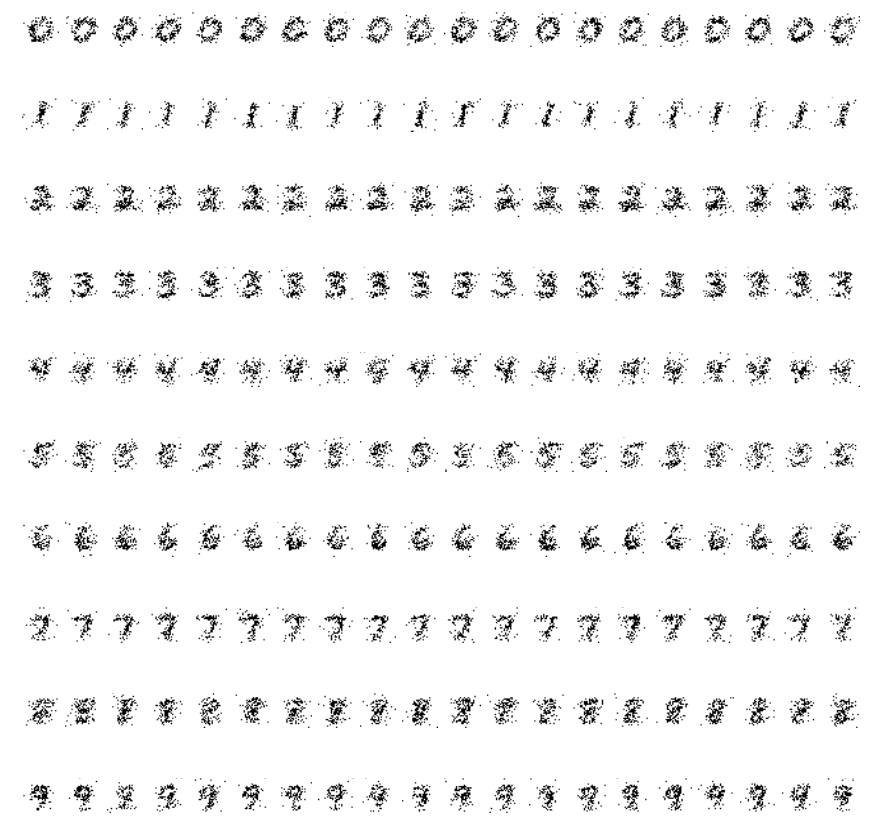

In [166]:
def P10(num_examples):
    # Train Bernoulli NB
    clf = BernoulliNB(binarize = 0.5, fit_prior=True, class_prior=None)
    clf.fit(mini_train_data, mini_train_labels)
    
    fig = plt.figure(figsize=(15, 15))
    # Generate 20 examples per digit
    for i in range(num_examples):
        for j in range(10):
            # Generate random array
            randArray = np.random.rand(784)
            mat = np.reshape([np.exp(clf.feature_log_prob_)[j] > randArray], (28,28))
            plt.subplot(10, num_examples, j * num_examples + i + 1)
            plt.imshow(mat, cmap = 'Greys')
            plt.axis('off')

P10(20)

ANSWER:

(11) Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?

In [167]:
def P11(buckets, correct, total):
    # Using alpha = 0.0001 from P8
    clf = BernoulliNB(alpha = 0.0001, binarize = 0.5, fit_prior=True, class_prior=None)
    clf.fit(mini_train_data, mini_train_labels)
    
    # Predict probablities for dev data
    post = clf.predict_proba(dev_data)   
    correctPred = np.zeros(len(dev_labels))
    for n in range(len(dev_labels)): 
        # Find bucket that has maximum posterior for each prediction
        correctPred[n] = np.argmax(post[n]) == dev_labels[n]        
        bucket = 0
        for i in buckets:
            # Update correct and total coutners
            if np.amax(post[n]) <= i:                
                correct[bucket] += correctPred[n]
                total[bucket] += 1
            else:
                bucket += 1

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

P11(buckets, correct, total)

for i in range(len(buckets)):
    accuracy = 0.0
    if (total[i] > 0): accuracy = correct[i] / total[i]
    print 'p(pred) <= %.13f    total = %3d    accuracy = %.3f' %(buckets[i], total[i], accuracy)

p(pred) <= 0.5000000000000    total =   0    accuracy = 0.000
p(pred) <= 0.9000000000000    total = 272    accuracy = 0.324
p(pred) <= 0.9990000000000    total = 553    accuracy = 0.456
p(pred) <= 0.9999900000000    total = 444    accuracy = 0.541
p(pred) <= 0.9999999000000    total = 340    accuracy = 0.735
p(pred) <= 0.9999999990000    total = 204    accuracy = 0.784
p(pred) <= 0.9999999999900    total = 192    accuracy = 0.797
p(pred) <= 0.9999999999999    total = 128    accuracy = 0.891
p(pred) <= 1.0000000000000    total = 566    accuracy = 0.940


ANSWER: The Naive Bayes model is weakly calibrated. The classifier is more accurate when the posterior is higher but the accuracy is not close to being equivalent.

(12) EXTRA CREDIT

Try designing extra features to see if you can improve the performance of Naive Bayes on the dev set. Here are a few ideas to get you started:
- Try summing the pixel values in each row and each column.
- Try counting the number of enclosed regions; 8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0.

Make sure you comment your code well!

In [18]:
#def P12():

### STUDENT START ###


### STUDENT END ###

#P12()